# Serving Alibi-Detect models

Out of the box, `mlserver` supports the deployment and serving of `alibi-detect` models. In this example, we will cover how we can create a detector configuration to then serve it using `mlserver`.

## Reference Data and Configuration

The first step will be to fetch a reference data for an `alibi-detect` model. For that, we will use the [alibi](https://github.com/SeldonIO/alibi) library.

Install Alibi dependencies for dataset and detector creation

In [ ]:
!pip install alibi alibi_detect

In [72]:
import alibi
import matplotlib.pyplot as plt
import numpy as np

In [73]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map = adult.category_map

In [74]:
n_ref = 10000
n_test = 10000

X_ref, X_t0, X_t1 = X[:n_ref], X[n_ref:n_ref + n_test], X[n_ref + n_test:n_ref + 2 * n_test]
categories_per_feature = {f: None for f in list(category_map.keys())}

In [75]:
cols = list(category_map.keys())
cat_names = [feature_names[_] for _ in list(category_map.keys())]
X_ref_cat, X_t0_cat = X_ref[:, cols], X_t0[:, cols]
X_ref_cat.shape, X_t0_cat.shape

((10000, 8), (10000, 8))

# Drift Detection

## TabularDrift

This example is based on the Categorical and mixed type data drift detection on income prediction from the [ `alibi-detect`](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_chi2ks_adult.html) documentation.

### Creating detector and saving configuration

In [76]:
from alibi_detect.cd import TabularDrift
cd_tabular = TabularDrift(X_ref, p_val=.05, categories_per_feature=categories_per_feature)

In [77]:
from alibi_detect.utils.saving import save_detector
filepath = "models/income-tabular-drift/detector_data"
save_detector(cd_tabular, filepath)

### Detecting Drift locally

In [78]:
preds = cd_tabular.predict(X_t0,drift_type="feature")

labels = ['No!', 'Yes!']
print(f"Threshold {preds['data']['threshold']}")
for f in range(cd_tabular.n_features):
    fname = feature_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- Chi2 {stat_val:.3f} -- p-value {p_val:.3f}')

Threshold 0.05
Age -- Drift? No! -- Chi2 0.012 -- p-value 0.508
Workclass -- Drift? No! -- Chi2 8.487 -- p-value 0.387
Education -- Drift? No! -- Chi2 4.753 -- p-value 0.576
Marital Status -- Drift? No! -- Chi2 3.160 -- p-value 0.368
Occupation -- Drift? No! -- Chi2 8.194 -- p-value 0.415
Relationship -- Drift? No! -- Chi2 0.485 -- p-value 0.993
Race -- Drift? No! -- Chi2 0.587 -- p-value 0.965
Sex -- Drift? No! -- Chi2 0.217 -- p-value 0.641
Capital Gain -- Drift? No! -- Chi2 0.002 -- p-value 1.000
Capital Loss -- Drift? No! -- Chi2 0.002 -- p-value 1.000
Hours per week -- Drift? No! -- Chi2 0.012 -- p-value 0.508
Country -- Drift? No! -- Chi2 9.991 -- p-value 0.441


## ChiSquareDrift

### Creating detector and saving configuration

In [79]:
from alibi_detect.cd import ChiSquareDrift
cd_chi2 = ChiSquareDrift(X_ref_cat, p_val=.05)

In [80]:
from alibi_detect.utils.saving import save_detector
filepath = "models/income-chi2-drift/detector_data"
save_detector(cd_chi2, filepath)

### Detecting Drift locally

In [81]:
preds = cd_chi2.predict(X_t0_cat,drift_type="feature")

labels = ['No!', 'Yes!']
print(f"Threshold {preds['data']['threshold']}")
for f in range(cd_chi2.n_features):
    fname = cat_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- Chi2 {stat_val:.3f} -- p-value {p_val:.3f}')

Threshold 0.05
Workclass -- Drift? No! -- Chi2 8.487 -- p-value 0.387
Education -- Drift? No! -- Chi2 4.753 -- p-value 0.576
Marital Status -- Drift? No! -- Chi2 3.160 -- p-value 0.368
Occupation -- Drift? No! -- Chi2 8.194 -- p-value 0.415
Relationship -- Drift? No! -- Chi2 0.485 -- p-value 0.993
Race -- Drift? No! -- Chi2 0.587 -- p-value 0.965
Sex -- Drift? No! -- Chi2 0.217 -- p-value 0.641
Country -- Drift? No! -- Chi2 9.991 -- p-value 0.441


# Outlier Detection

## Variational Auto-Encoder (VAE) outlier detection

This example is based on the VAE outlier detection for income prediction from the [ `alibi-detect`](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_vae_adult.html#) documentation.

In [82]:
import tensorflow as tf
from alibi_detect.utils.perturbation import inject_outlier_tabular

tf.keras.backend.clear_session()


def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)


set_seed(0)
Xy_perm = np.random.permutation(np.c_[X, y])
X, y = Xy_perm[:, :-1], Xy_perm[:, -1]

keep_cols = [2, 3, 5, 0, 8, 9, 10]
od_feature_names = (
    feature_names[2:4] + feature_names[5:6] + feature_names[0:1] + feature_names[8:11]
)

X = X[:, keep_cols]
category_map_tmp = adult.category_map
category_map = {}
i = 0
for k, v in category_map_tmp.items():
    if k in keep_cols:
        category_map[i] = v
        i += 1

minmax = False
X_num = X[:, -4:].astype(np.float32, copy=False)
if minmax:
    xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
    rng = (-1.0, 1.0)
    X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]
else:  # normalize
    mu, sigma = X_num.mean(axis=0), X_num.std(axis=0)
    X_num_scaled = (X_num - mu) / sigma

from sklearn.preprocessing import OneHotEncoder

X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_cat)

X = np.c_[X_cat, X_num_scaled].astype(np.float32, copy=False)
n_train = 25000
n_valid = 5000
X_train, y_train = X[:n_train, :], y[:n_train]
X_valid, y_valid = X[n_train : n_train + n_valid, :], y[n_train : n_train + n_valid]
X_test, y_test = X[n_train + n_valid :, :], y[n_train + n_valid :]
print(
    X_train.shape,
    y_train.shape,
    X_valid.shape,
    y_valid.shape,
    X_test.shape,
    y_test.shape,
)

cat_cols = list(category_map.keys())
num_cols = [col for col in range(X.shape[1]) if col not in cat_cols]


perc_outlier = 10
data = inject_outlier_tabular(X_valid, num_cols, perc_outlier, n_std=8.0, min_std=6.0)
X_threshold, y_threshold = data.data, data.target
X_threshold_, y_threshold_ = (
    X_threshold.copy(),
    y_threshold.copy(),
)  # store for comparison later
outlier_perc = 100 * y_threshold.sum() / len(y_threshold)
print("{:.2f}% outliers".format(outlier_perc))

outlier_idx = np.where(y_threshold != 0)[0]
vdiff = X_threshold[outlier_idx[0]] - X_valid[outlier_idx[0]]
fdiff = np.where(vdiff != 0)[0]
print("{} changed by {:.2f}.".format(od_feature_names[fdiff[0]], vdiff[fdiff[0]]))

data = inject_outlier_tabular(X_test, num_cols, perc_outlier, n_std=8.0, min_std=6.0)
X_outlier, y_outlier = data.data, data.target
print("{:.2f}% outliers".format(100 * y_outlier.sum() / len(y_outlier)))

X_train_ohe = ohe.transform(X_train[:, :-4].copy())
X_threshold_ohe = ohe.transform(X_threshold[:, :-4].copy())
X_outlier_ohe = ohe.transform(X_outlier[:, :-4].copy())
print(X_train_ohe.shape, X_threshold_ohe.shape, X_outlier_ohe.shape)

X_train = np.c_[X_train_ohe.toarray(), X_train[:, -4:]].astype(np.float32, copy=False)
X_threshold = np.c_[X_threshold_ohe.toarray(), X_threshold[:, -4:]].astype(
    np.float32, copy=False
)
X_outlier = np.c_[X_outlier_ohe.toarray(), X_outlier[:, -4:]].astype(
    np.float32, copy=False
)
print(X_train.shape, X_threshold.shape, X_outlier.shape)



(25000, 7) (25000,) (5000, 7) (5000,) (2561, 7) (2561,)
9.50% outliers
Age changed by -6.01.
9.49% outliers
(25000, 17) (5000, 17) (2561, 17)
(25000, 21) (5000, 21) (2561, 21)


In [83]:
from alibi_detect.utils.fetching import fetch_detector

load_outlier_detector = True
filepath = "models/income-vae-outlier/detector_data"  # change to directory where model is downloaded

if load_outlier_detector:  # load pretrained outlier detector
    detector_type = "outlier"
    dataset = "adult"
    detector_name = "OutlierVAE"
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    n_features = X_train.shape[1]
    latent_dim = 2

    encoder_net = tf.keras.Sequential(
        [
            InputLayer(input_shape=(n_features,)),
            Dense(25, activation=tf.nn.relu),
            Dense(10, activation=tf.nn.relu),
            Dense(5, activation=tf.nn.relu),
        ]
    )

    decoder_net = tf.keras.Sequential(
        [
            InputLayer(input_shape=(latent_dim,)),
            Dense(5, activation=tf.nn.relu),
            Dense(10, activation=tf.nn.relu),
            Dense(25, activation=tf.nn.relu),
            Dense(n_features, activation=None),
        ]
    )

    # initialize outlier detector
    od = OutlierVAE(
        threshold=None,  # threshold for outlier score
        score_type="mse",  # use MSE of reconstruction error for outlier detection
        encoder_net=encoder_net,  # can also pass VAE model instead
        decoder_net=decoder_net,  # of separate encoder and decoder
        latent_dim=latent_dim,
        samples=5,
    )

    # train
    od.fit(X_train, loss_fn=tf.keras.losses.mse, epochs=5, verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

od.infer_threshold(X_threshold, threshold_perc=100 - outlier_perc, outlier_perc=100)
print("New threshold: {}".format(od.threshold))

save_detector(od, filepath)

Trying to load detector from version 0.7.3dev when using version 0.8.1. This may lead to breaking code or invalid results.
No threshold level set. Need to infer threshold using `infer_threshold`.


New threshold: 1.52375670015812


### Detecting Outliers locally

In [84]:
od_preds = od.predict(X_outlier,
                      outlier_type='instance',
                      return_feature_score=True,
                      return_instance_score=True)

F1 score: 0.90 -- Accuracy: 0.98 -- Precision: 0.89 -- Recall: 0.90


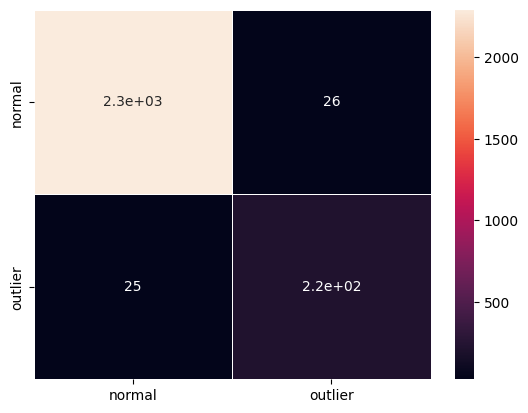

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
import seaborn as sns
labels = data.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
prec = precision_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {:.2f} -- Accuracy: {:.2f} -- Precision: {:.2f} -- Recall: {:.2f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

## Serving

Now that we have the reference data and other configuration parameters, the next step will be to serve it using `mlserver`. 
For that, we will need to create 2 configuration files: 

- `settings.json`: holds the configuration of our server (e.g. ports, log level, etc.).
- `model-settings.json`: holds the configuration of our model (e.g. input type, runtime to use, etc.).

### `settings.json`

In [86]:
%%writefile settings.json
{
    "debug": "true"
}

Overwriting settings.json


### `model-settings.json`

In [87]:
%%writefile models/income-tabular-drift/model-settings.json
{
  "name": "income-tabular-drift",
  "implementation": "mlserver_alibi_detect.AlibiDetectRuntime",
  "parameters": {
    "uri": "./detector_data",
    "version": "v0.1.0"
  }
}

Overwriting models/income-tabular-drift/model-settings.json


In [88]:
%%writefile models/income-chi2-drift/model-settings.json
{
  "name": "income-chi2-drift",
  "implementation": "mlserver_alibi_detect.AlibiDetectRuntime",
  "parameters": {
    "uri": "./detector_data",
    "version": "v0.1.0"
  }
}

Overwriting models/income-chi2-drift/model-settings.json


In [89]:
%%writefile models/income-vae-outlier/model-settings.json
{
  "name": "income-vae-outlier",
  "implementation": "mlserver_alibi_detect.AlibiDetectRuntime",
  "parameters": {
    "uri": "./detector_data",
    "version": "v0.1.0"
  }
}

Overwriting models/income-vae-outlier/model-settings.json


### Start serving our model

Now that we have our config in-place, we can start the server by running `mlserver start .`. This needs to either be ran from the same directory where our config files are or pointing to the folder where they are.

```shell
mlserver start .
```

Since this command will start the server and block the terminal, waiting for requests, this will need to be ran in the background on a separate terminal.

### Send test inference request

We now have our model being served by `mlserver`.
To make sure that everything is working as expected, let's send a request from our test set.

For that, we can use the Python types that `mlserver` provides out of box, or we can build our request manually.

### Tabular Drift

In [91]:
import requests

inference_request = {
    "inputs": [
        {
            "name": "predict",
            "shape": X_t0.shape,
            "datatype": "FP32",
            "data": X_t0.tolist(),
        }
    ],
    "parameters":{
        "predict_kwargs":{
            "drift_type":"feature"
        }
    }
}

endpoint = "http://localhost:8080/v2/models/income-tabular-drift/versions/v0.1.0/infer"
response = requests.post(endpoint, json=inference_request)

In [92]:
import json
response_dict = json.loads(response.text)

labels = ['No!', 'Yes!']
for f in range(cd_tabular.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = response_dict['outputs'][0]['data'][f]
    print(f'{fname} -- Drift? {labels[is_drift]}')

Age -- Drift? No!
Workclass -- Drift? No!
Education -- Drift? No!
Marital Status -- Drift? No!
Occupation -- Drift? No!
Relationship -- Drift? No!
Race -- Drift? No!
Sex -- Drift? No!
Capital Gain -- Drift? No!
Capital Loss -- Drift? No!
Hours per week -- Drift? No!
Country -- Drift? No!


### Chi-square Drift

In [93]:
import requests

inference_request = {    
    "inputs": [
        {
            "name": "predict",
            "shape": X_t0_cat.shape,
            "datatype": "FP32",
            "data": X_t0_cat.tolist(),
        }
    ],
    "parameters":{
        "predict_kwargs":{
            "drift_type":"feature"
        }
    }
}

endpoint = "http://localhost:8080/v2/models/income-chi2-drift/versions/v0.1.0/infer"
response = requests.post(endpoint, json=inference_request)

In [94]:
import json
response_dict = json.loads(response.text)

labels = ['No!', 'Yes!']
for f in range(cd_chi2.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = response_dict['outputs'][0]['data'][f]
    print(f'{fname} -- Drift? {labels[is_drift]}')

Age -- Drift? No!
Workclass -- Drift? No!
Education -- Drift? No!
Marital Status -- Drift? No!
Occupation -- Drift? No!
Relationship -- Drift? No!
Race -- Drift? No!
Sex -- Drift? No!


### VAE Outlier

In [95]:
import requests

inference_request = {    
    "inputs": [
        {
            "name": "predict",
            "shape": X_outlier.shape,
            "datatype": "FP32",
            "data": X_outlier.tolist(),
        }
    ],
    "parameters":{
        "predict_kwargs":{
            "outlier_type":"instance"
        }
    }
}

endpoint = "http://localhost:8080/v2/models/income-vae-outlier/versions/v0.1.0/infer"
response = requests.post(endpoint, json=inference_request)

F1 score: 0.89 -- Accuracy: 0.98 -- Precision: 0.89 -- Recall: 0.89


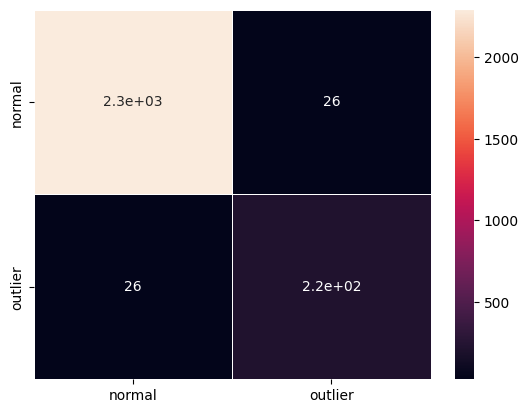

In [96]:
import json
response_dict = json.loads(response.text)

labels = data.target_names
y_pred = response_dict['outputs'][2]['data']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
prec = precision_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {:.2f} -- Accuracy: {:.2f} -- Precision: {:.2f} -- Recall: {:.2f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()